# Lab Assignment 10

In [3]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport


In [5]:
# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from tqdm import tqdm_notebook

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.plotting import plot_mat

sns.set_style("whitegrid")



In [9]:
# @title Data Loading
# We will load a few commonly used datasets:
# - mushroom
# - iris
# - adult
# - congressional voting
# - german credit


# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
    "target",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat",
]

# Use read_csv to load the data.
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

# 2. Iris
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_df = pd.read_csv(
    iris_url,
    header=None,
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "target"],
)


# Problem 1 [2p] 

Download a categorical dataset, such as the [mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom) from UCI and try to find the most predictive variables: 

### Implement mutual information [1p]

Implement the function `entropy` to compute the entropy of a column of the dataset.

The [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete variable is defined to be:

$$H(X) = -\sum_x p_X(x) \log_2 p_X(x).$$

A good in tutorial is given by Chris Olah: https://colah.github.io/posts/2015-09-Visual-Information/.


When $X$ is a discrete random variable, we can estimate the probabilities with counts:

$$p_X(x) = \frac{\text{number of instances where }X=x}{\text{total number of instances}}.$$


Hint: the following `pandas` functions may be useful:
- `count`
- `value_count`

Then use the dataframe's `apply` function to compute the entropy of all columns.

In [10]:
def entropy(series):
    probs = series.value_counts() / series.count()
    log_probs = np.log2(probs)
    return -np.sum(probs * log_probs)

mushroom_df.apply(entropy)

target                      0.999068
cap-shape                   1.652889
cap-surface                 1.575486
cap-color                   2.510143
bruises?                    0.979327
odor                        2.319414
gill-attachment             0.173129
gill-spacing                0.637878
gill-size                   0.892256
gill-color                  3.030433
stalk-shape                 0.986927
stalk-root                  1.822922
stalk-surface-above-ring    1.221348
stalk-surface-below-ring    1.399135
stalk-color-above-ring      1.936809
stalk-color-below-ring      1.978163
veil-type                  -0.000000
veil-color                  0.196238
ring-number                 0.420680
ring-type                   1.535121
spore-print-color           2.203227
population                  2.003398
habitat                     2.274747
dtype: float64

Implement the conditional entropy computation

$$H(Y|X) = \sum_x p_X(x) H(Y|x) = \sum_x p_X(x) \sum_y p_Y(y|x) \log_2 p_Y(y|x)$$

Hint 1: the above formula can be computed as follows:
1. split the data by the values of $X$
2. for each value $x$ that $X$ takes, compute the entropy of $Y$
3. average the entropies, weighing them by how frequently the value $x$ occured.

Hint 2: helpful pandas constructs are:
- `groupby` and `agg`
- you can aggregate a grouping using your own custom functions


In [11]:
mushroom_df['target'].value_counts()

e    4208
p    3916
Name: target, dtype: int64

In [12]:
mushroom_df['odor'].value_counts()

n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64

In [13]:
def cond_probability(X, Y):
    x_given_y = pd.crosstab(X, Y, normalize='columns') # index means normalize over rows
    return x_given_y

In [15]:
def cond_entropy(X, Y):
    """Compute the conditional H(X|Y) in dataframe df
    Args:
        X: series whose entropy we wish to compute
        Y: series on which we condition
    """
    x_given_y = cond_probability(X, Y)
    py = Y.value_counts() / Y.count()
    with np.errstate(divide='ignore'):
        ent_ys = np.log2(x_given_y) * x_given_y
    return -(ent_ys.sum(axis=0) * py).sum()

for cname in mushroom_df.columns:
    print(f"{cname.ljust(25)}:\t {cond_entropy(mushroom_df['target'], mushroom_df[cname]).round(decimals=3)}")

target                   :	 -0.0
cap-shape                :	 0.95
cap-surface              :	 0.97
cap-color                :	 0.963
bruises?                 :	 0.807
odor                     :	 0.093
gill-attachment          :	 0.985
gill-spacing             :	 0.898
gill-size                :	 0.769
gill-color               :	 0.582
stalk-shape              :	 0.992
stalk-root               :	 0.864
stalk-surface-above-ring :	 0.714
stalk-surface-below-ring :	 0.727
stalk-color-above-ring   :	 0.745
stalk-color-below-ring   :	 0.758
veil-type                :	 0.999
veil-color               :	 0.975
ring-number              :	 0.961
ring-type                :	 0.681
spore-print-color        :	 0.518
population               :	 0.797
habitat                  :	 0.842


In [16]:
def mutual_information(X, Y):
    # TODO implement mutual information using the formula H(X,Y) - H(X|Y) - H(Y|X)
    return entropy(X) - cond_entropy(X, Y)
    
for cname in mushroom_df.columns:
    print(f"{cname.ljust(25)}:\t {mutual_information(mushroom_df['target'], mushroom_df[cname]).round(decimals=3)}")

target                   :	 0.999
cap-shape                :	 0.049
cap-surface              :	 0.029
cap-color                :	 0.036
bruises?                 :	 0.192
odor                     :	 0.906
gill-attachment          :	 0.014
gill-spacing             :	 0.101
gill-size                :	 0.23
gill-color               :	 0.417
stalk-shape              :	 0.008
stalk-root               :	 0.135
stalk-surface-above-ring :	 0.285
stalk-surface-below-ring :	 0.272
stalk-color-above-ring   :	 0.254
stalk-color-below-ring   :	 0.241
veil-type                :	 0.0
veil-color               :	 0.024
ring-number              :	 0.038
ring-type                :	 0.318
spore-print-color        :	 0.481
population               :	 0.202
habitat                  :	 0.157


We can see from the above listing that the features that share the most information with the target are "odor" (0.906). Makes sense, also there was the biggest drop in the conditional entropy in the target column when conditioned on the odor.

## Correlation vs mutual information

Here's an example for why we care about mutual information in the first place.
There are very natural cases when correlation of two random variables is very low (in the example it's actually a perfect 0), even though they may be incredibly dependent. It turns out that zero correlation only tells us whether two random variables do not have any linear relationship between them.

,x,|x|
-1.0,-1.0,1.0
0.0,0.0,0.0
1.0,1.0,1.0


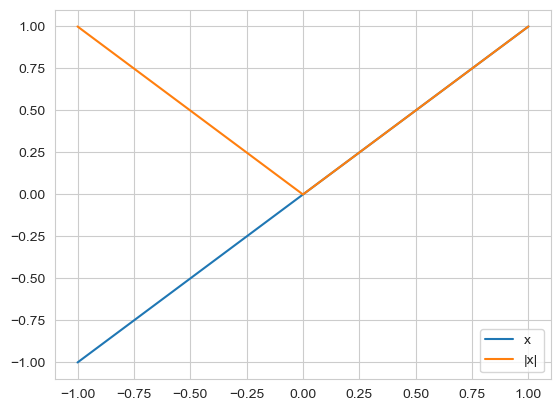

In [17]:
df = pd.DataFrame(index=np.linspace(-1,1,3))
df['x'] = df.index
df['|x|'] = np.abs(df['x'])
df.plot()
df

Correlation (covariance) of random variables X and |X| is 0.

In [18]:
df['x'].dot(df['|x|'])

0.0

However, they are very dependent, since knowing $x$ immediately tells us what the value of $|x|$ is. 
And this actually can be seen by looking at the conditional entropy of $H(|X|\ | X)$ the variables.

In [19]:
cond_entropy(df["|x|"], df["x"]).round(decimals=9)

-0.0

The above result clearly implements our intuition --- once we know $x$, there's no uncertainty left about $|x|$.

What about the reverse conditioning?

In [20]:
entropy(df['x']), np.log2(3)

(1.584962500721156, 1.584962500721156)

In [22]:
entropy(df['|x|']),  (1/3)*np.log2(3) + (2/3)*np.log2(3/2)

(0.9182958340544896, 0.9182958340544893)

In [24]:
cond_entropy(df["x"], df["|x|"]).round(decimals=3)

0.6666666666666666

This result has a natural intepretation: 1 cases out of 3 $|x|$ is zero in which case we know what $x$ is, so in this case the entropy is $0$, cause there's no uncertainty left. 2 cases out of 3 we have $|x| = 1$, in which case the uncertainty which remains is the probability distribution of the sign. The probability distribution of the sign is just $P(\mbox{sign is }+) = 1/2 = P(\mbox{sign is }-)$ and its entropy is $-\left(\frac{1}{2}\log(1/2) + \frac{1}{2}\log(1/2)\right)=1$. Hence the total conditional entropy is $\frac{2}{3}$.

At the end let us look at the actual mutual information based on what we already saw.

In [25]:
mutual_information(df['x'], df['|x|'])

0.9182958340544894

Makes sense, right?

# Problem 2: Decision Tree Implementation [9p]

Currently, there are no good implementations of Decision Trees in Python.

Sadly, the machine learning toolkit [sklearn](https://scikit-learn.org/stable/index.html) doesn't handle categorical attributes. Let's use this as an excuse to implement Decision Tress ourselves.



## Decision Tree Task 

In the following code change the criterion from Gini to entropy

In [26]:
import numpy as np
import pandas as pd
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris()

# Create a dataframe from the iris data
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Define a function to calculate the Gini index
def gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Define a function to split the data into two groups
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Define a function to find the best split for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Define a function to create a terminal node
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Define a function to create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
        # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

# Define a function to build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Define a function to make predictions with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Train the decision tree on the Iris dataset
dataset = df.values.tolist()
tree = build_tree(dataset, max_depth=3, min_size=1)

# Make predictions on the Iris dataset using the trained decision tree
predictions = [predict(tree, row) for row in dataset]


In [27]:
predictions

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0]

In [29]:
(predictions == y).mean()

0.9733333333333334